# Finlab x FinMind 處置股事件研究
本 Notebook 整合 Finlab 處置資訊與 FinMind 股價資料，進行事件研究 (Event Study)。

In [2]:
# [Env Setup] 載入必要套件與設定
import pandas as pd
from tqdm import tqdm
from loguru import logger
import sys
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
sys.path.append("/Users/xinc./Documents/GitHub/note")
sys.path.append(os.getcwd()) # 加入目前路徑以匯入 utils

from module.get_info_FinMind import FinMindClient, FinMindConfig
from module.get_info_Finlab import FinlabClient
from module.plot_func import plot
from utils import batch_fetch_prices, run_event_study, process_disposal_events

In [21]:
# [Step 1] 抓取 Finlab 處置股資料
# 若需要 Token，請在初始化時傳入，例如 FinlabClient(token="YOUR_TOKEN")
finlab_client = FinlabClient()
print("Fetching disposal information from Finlab...")

# 抓取資料 (設定較大的範圍以確保涵蓋需求)
finlab_disposal = finlab_client.get_data("disposal_information", start_date='2018-01-01')

# [Manual Filter] 手動篩選日期 (修正 Finlab API 時間過濾限制)
if not finlab_disposal.empty:
    finlab_disposal['date'] = pd.to_datetime(finlab_disposal['date'])
    finlab_disposal = finlab_disposal[finlab_disposal['date'] >= '2018-01-01']
    print(f"Fetched {len(finlab_disposal)} records from Finlab.")
    print(f"Data Range: {finlab_disposal['date'].min()} to {finlab_disposal['date'].max()}")
else:
    print("No data fetched from Finlab.")

Fetching disposal information from Finlab...
Fetched 3383 records from Finlab.
Data Range: 2018-01-04 00:00:00 to 2025-09-26 00:00:00


In [22]:
# [Step 1.5] 前處理與分級 (Preprocessing)
# 這一步會先將 Finlab 處置資料整理格式，並標記 First/Second Disposal
if 'finlab_disposal' in locals() and not finlab_disposal.empty:
    print("Processing disposal events...")
    processed_disposal = process_disposal_events(finlab_disposal)
    
    # print(f"Processed Data Shape: {processed_disposal.shape}")
    # display(processed_disposal.head())
    
    # Optional: Save for inspection
    processed_disposal.to_csv('processed_disposal_events.csv', index=False, encoding='utf-8-sig')
else:
    print("Finlab data not available. Please run Step 1 first.")
    processed_disposal = pd.DataFrame()

Processing disposal events...
Columns before processing: ['Stock_id', 'date', '證券名稱', 'condition', '處置措施', '處置內容', 'event_start_date', 'event_end_date', 'interval', 'key_date']
Processed 3383 events.
Level Distribution:
disposal_level
1     2702
2      453
3      110
4       36
5       17
6        8
7        6
8        5
9        5
10       4
11       4
12       4
13       3
14       3
15       3
16       3
17       3
18       3
19       3
20       2
21       2
22       2
23       1
24       1
Name: count, dtype: int64


In [ ]:
# [Step 2] 平行化抓取股價 (FinMind)
# 使用處理過的事件表 (processed_disposal) 以確保連續處置區間不遺漏
logger.remove()
logger.add(sys.stderr, level="WARNING")

# Initialize FinMind Client
fm_client = FinMindClient()


if 'processed_disposal' in locals() and not processed_disposal.empty:
    # 開始抓取
    price_df = batch_fetch_prices(fm_client, processed_disposal, offset_days=5, max_workers=10)

    if not price_df.empty:
        print(f"Fetched Price Data Shape: {price_df.shape}")
        display(price_df.head())
    else:
        print("No price data fetched.")
else:
    print("No processed disposal data found. Please run Step 1.5.")

gc.collect()

Using pre-processed columns 'event_start_date' and 'event_end_date'.
Starting batch fetch for 1317 stocks with 10 workers...


python(3990) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Fetching Prices: 100%|██████████| 1317/1317 [00:39<00:00, 33.09it/s]


Fetched total 37289 rows.
Fetched Price Data Shape: (37289, 8)
        Date Stock_id   Open   High    Low  Close     Volume  TradingAmount
0 2024-10-07    00887  18.11  38.83  18.11  38.83   83803000     1941768900
1 2024-10-08    00887  31.43  33.00  19.81  20.00  122882000     3072512130
2 2024-10-09    00887  22.00  26.10  21.20  23.00  141019000     3247752990
3 2024-10-11    00887  25.30  25.30  21.15  22.15   16763000      392850590
4 2024-10-14    00887  12.49  18.66   8.50  10.86  105852000     1033130290


5406

In [27]:
# [Step 3] 執行 Event Study 分析
# 使用 processed_disposal，其中已經包含 is_first_disposal 等標記
offset_days = 3
disposal_wide, disposal_long = run_event_study(price_df, processed_disposal, offset_days=offset_days)

if not disposal_wide.empty:
    print(f"Wide Format Shape: {disposal_wide.shape}")
    print(f"Long Format Shape: {disposal_long.shape}")
    
    print("\n[Wide Head]")
    display(disposal_wide.head())
    
    print("\n[Long Head]")
    display(disposal_long.head())
    
    # Save both files
    disposal_wide.to_csv('disposal_df_wide.csv', index=False, encoding='utf-8-sig')
    disposal_long.to_csv('disposal_df_long.csv', index=False, encoding='utf-8-sig')
    print("Saved 'disposal_df_wide.csv' and 'disposal_df_long.csv'.")
    
    # For compatibility, save wide as original name too
    disposal_wide.to_csv('disposal_df.csv', index=False, encoding='utf-8-sig')
else:
    print("Analysis returned empty DataFrame.")

Detected Disposal Levels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]
Converting to Wide Format...


UnboundLocalError: cannot access local variable 'final_df' where it is not associated with a value

平均日報酬 (依 t_label 分組):
             t_label  daily_ret
relative_day                   
-3               t-3   0.007148
-2               t-2   0.007431
-1               t-1  -0.000716
 0               t+0  -0.009030
 1               t+1  -0.003639
 2               t+2   0.001736
 3               t+3  -0.000497


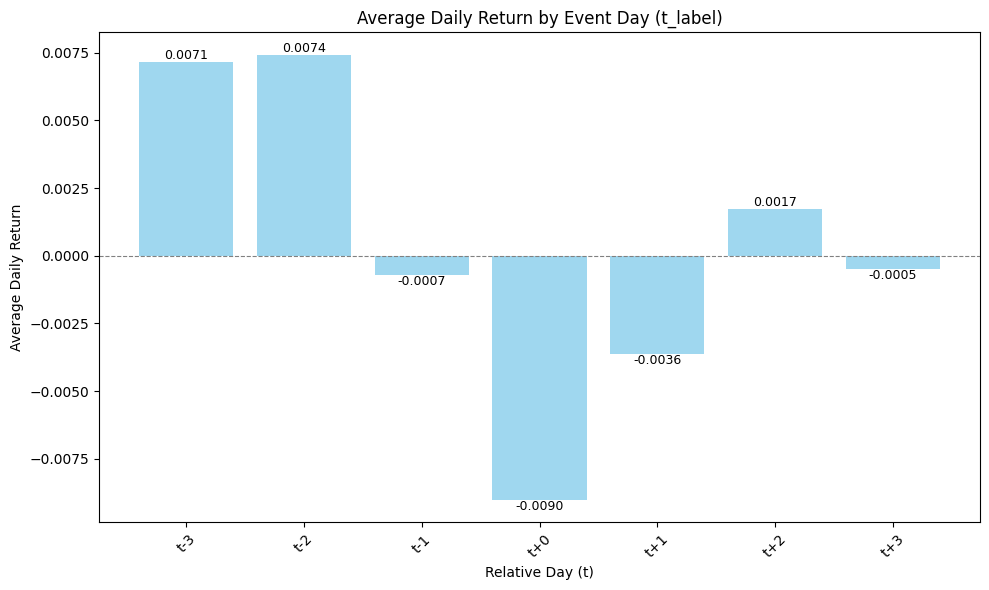

In [11]:
# [Step 4] 統計與視覺化 (Using Long Format)
if 'disposal_long' in locals() and not disposal_long.empty:
    target_df = disposal_long
    
    # 依相對天數與等級計算平均日報酬 (Daily Return)
    daily_ret_stats = target_df.groupby(['relative_day', 'disposal_level'])[['daily_ret']].mean().reset_index()
    
    # Map t_label (Just construct it)
    def format_t(x):
        if x > 0: return f't+{x}'
        elif x < 0: return f't{x}'
        else: return 't+0'
    daily_ret_stats['t_label'] = daily_ret_stats['relative_day'].apply(format_t)
    
    print("平均日報酬 (前 5 筆):")
    print(daily_ret_stats.head())
    
    # Plotting - Level 1 vs Level 2
    plt.figure(figsize=(12, 6))
    
    # Filter for reasonable range
    plot_data = daily_ret_stats[daily_ret_stats['relative_day'].between(-5, 10)]
    
    sns.barplot(data=plot_data, x='t_label', y='daily_ret', hue='disposal_level')
    
    plt.title('Average Daily Return by Event Day & Level')
    plt.ylabel('Average Daily Return')
    plt.xlabel('Relative Day (t)')
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization.")